<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-and-imports" data-toc-modified-id="Setup-and-imports-1">Setup and imports</a></span><ul class="toc-item"><li><span><a href="#import-US-states-geometry" data-toc-modified-id="import-US-states-geometry-1.1">import US states geometry</a></span><ul class="toc-item"><li><span><a href="#aside:-test-morphing-concept-on-state-border-map" data-toc-modified-id="aside:-test-morphing-concept-on-state-border-map-1.1.1">aside: test morphing concept on state border map</a></span></li></ul></li><li><span><a href="#import-roads" data-toc-modified-id="import-roads-1.2">import roads</a></span><ul class="toc-item"><li><span><a href="#aside:-visualize-effect-of-dropping-points" data-toc-modified-id="aside:-visualize-effect-of-dropping-points-1.2.1">aside: visualize effect of dropping points</a></span></li></ul></li><li><span><a href="#import-cities" data-toc-modified-id="import-cities-1.3">import cities</a></span><ul class="toc-item"><li><span><a href="#aside:-test-city-label-automatic-placement" data-toc-modified-id="aside:-test-city-label-automatic-placement-1.3.1">aside: test city label automatic placement</a></span></li></ul></li></ul></li><li><span><a href="#chronomaps:-morph-images-according-to-travel-times" data-toc-modified-id="chronomaps:-morph-images-according-to-travel-times-2">chronomaps: morph images according to travel times</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#aside:-interpolation-routines" data-toc-modified-id="aside:-interpolation-routines-2.0.1">aside: interpolation routines</a></span></li></ul></li><li><span><a href="#make-chronomaps" data-toc-modified-id="make-chronomaps-2.1">make chronomaps</a></span></li></ul></li><li><span><a href="#chronomaps-for-other-US-cities" data-toc-modified-id="chronomaps-for-other-US-cities-3">chronomaps for other US cities</a></span></li><li><span><a href="#Animations" data-toc-modified-id="Animations-4">Animations</a></span><ul class="toc-item"><li><span><a href="#batch-animations" data-toc-modified-id="batch-animations-4.1">batch animations</a></span></li></ul></li></ul></div>

#  Setup and imports

In [1]:
import chronomaps as krm

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from shapely.geometry import Point
from matplotlib.patches import Path, PathPatch, Polygon, Wedge, Circle, Rectangle, FancyBboxPatch
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text # to adjust city labels on maps

from scipy.interpolate import interp2d, NearestNDInterpolator, LinearNDInterpolator, Rbf

In [4]:
# import mpl_toolkits
# mpl_toolkits.__path__.append('/usr/local/lib/python2.7/dist-packages/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap

In [5]:
# define green/yellow/red colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list('GreenYellowRed',['limegreen', 'gold','darkred'])

In [7]:
def patch_mask_oceans_lakes(themap0, ax, morph_func='', aquacolor='lightcyan', zorder=90, lw=0):
    """
    Create a water-blue patch covering up water bodies (oceans and lakes).
    If morph_func != '', morph the boundaries of bodies of water according to travel times.
    In that case, make sure to pass a 'cyl' basemap, so that the points in themap are (lon,lat) and we can feed them to
    the travel time interpolating function.
    Ocean masking code taken from https://stackoverflow.com/questions/48620803/fill-oceans-in-basemap
    """
    patches = []
    # fill lakes
    for lake in  [f.boundary for f in themap0.lakepolygons]:
        mbo = lake if morph_func=='' else [morph_func(pp) for pp in lake] 
        patches.append(Polygon(mbo,facecolor=aquacolor, edgecolor='0.3',lw=lw,zorder=zorder))
    
    # fill oceans
    (x0,x1),(y0,y1) = ax.get_xlim(), ax.get_ylim()
    map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])
    polys = [map_edges]

    for line in [f.boundary for f in themap0.landpolygons]:
        mbo = line if morph_func=='' else [morph_func(pp) for pp in line]
        polys.append(mbo)
        
    ##creating a PathPatch
    codes = [ [Path.MOVETO] + [Path.LINETO for p in p[1:]] for p in polys ]
    polys_lin = [v for p in polys for v in p]
    codes_lin = [c for cs in codes for c in cs]
    patches.append(PathPatch(Path(polys_lin, codes_lin), facecolor=aquacolor, edgecolor='0.3', lw=lw, zorder=zorder))
    return patches

In [96]:
def make_contour_map(x,y,z, ax, projmap, p0, levels, plot_states=True, plot_cities=True, dist_cut=25, n_cities_cut=20, plot_roads=True, roads='', plot_water=True, cbarlabel='Travel time (hours)'):
    """
    Given an x,y grid with values z for each point, plot contours of constant z at the specified levels.
    Additional arguments are:
        - plot_states, plot_cities, plot_roads, plot_water: if True, plot US state borders, cities (with labels) in the range
        being plotted, US interstates, and a water layer for oceans and lakes.
        - if plot_cities=True, additional arguments are used to limit the number of cities shown on the map. In particular,
        all cities within dist_cut of each other are merged, and only the largest n_cities_cut cities are shown on the map.
        - if cbarlabel contains the string 'hours', the colorbar labels will be given by levels/60, that is, in hours (because z and levels are given in minutes).
    """
    z = np.array(z)/60. if 'hours' in cbarlabel else zz
    levs = np.array(levels)/60. if 'hours' in cbarlabel else levels
    cols = [cmap(1.*lev/levels[-1]) for lev in levels]

    if plot_water and not isinstance(projmap,Basemap):
        raise Exception('Trying to plot water layer but did not receive projection. Input should be projmap = basemap')
    
    # if plotting latlon points, leave projmap to be the identity
    if projmap == '': projmap = lambda x,y: (x,y); rebox=0.02
    else: rebox = 10**4.2
    
    
    x_range, y_range = map(lambda f: f(x),[min,max]), map(lambda f: f(y),[min,max])
    LL, UR = projmap(x_range[0],y_range[0]), projmap(x_range[1],y_range[1])
    ax.set(xlim=(LL[0],UR[0]), ylim=(LL[1],UR[1]))

    if plot_roads and roads=='':
        raise Exception('Trying to plot roads but did not receive list of roads as input. Input should be roads=<list of [name, [[lon1,lat1],...]>')

    # plot states in range
    if plot_states:
        states = [st for st in state_border.keys() if any([krm.is_in_range(pp,x_range,y_range,) for pp in zip(*state_border[st])])]
        for st in states:
            ax.plot(*projmap(*state_border[st]),c='0.3',zorder=2)
    
    # plot roads
    if plot_roads:
        for name, road in roads:
            ax.plot(*projmap(*zip(*road)), c='k',lw=0.5)
    
    # plot main cities
    if plot_cities:
        cities = [[ci['longitude'],ci['latitude'],ci['name'],ci['population']] for ci in 
              sorted([ ci for ci in cities_us if krm.is_in_range([ci['longitude'], ci['latitude']],x_range, y_range)]
                     , key = lambda ci: ci['population'], reverse=True) ]
        cities = cluster_cities(cities)
        cities_plot = [ci for ci in cities if len(ci)>4]
        texts=[]
        for ci in reversed(cities_plot[:n_cities_cut]): # biggest city last
            mci = projmap(ci[0], ci[1]) 
            ax.scatter(*mci,c='k',zorder=100,**map_point_style(ci[-1]))
            if krm.is_in_range(mci, ax.get_xlim(),ax.get_ylim()):
                font = map_font_style(ci[-1], extradict={'color':'darkblue'})
                texts.append(ax.text(*mci, s=reformat_name(ci[2]), fontdict=font, zorder=100))
        for txt in texts: txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
    
    
    # make travel time contours
    xm, ym = projmap(x,y)
    ax.tricontour(xm,ym,z, levels=levs, colors=map(lambda c: krm.lighten_color(c,1.2), cols),linewidths=1,zorder=0)
    im = ax.tricontourf(xm,ym,z, levels=levs, colors=cols, alpha=0.5, antialiased=True,extend='max',zorder=0)
    if cbarlabel!='':
        cb = plt.colorbar(im, ax=ax, label=cbarlabel, fraction=0.045, extendfrac=0.)
        cb.set_alpha(0.7)
        cb.draw_all()
    ax.set_axis_off()
    
    # add ocean/lake layer: set zorder=0 for the water layer to be under the color rings
    if plot_water: 
        patches = patch_mask_oceans_lakes(projmap, ax, aquacolor='lightcyan',zorder=3,lw=1)
        for p in patches: ax.add_patch(p)

    ax.set(xlim=np.array(ax.get_xlim())+(rebox,-rebox), ylim=np.array(ax.get_ylim())+(rebox,-rebox), aspect=1)
    fig.tight_layout()
    if plot_cities: _=adjust_text(texts, ax=ax)

    return ax

In [125]:
def make_chronomap(x,y,z, ax, projmap, p0, levels, lim = 155, plot_states=True, plot_cities=True, dist_cut=25, n_cities_cut=20, small_city_radius=0, plot_roads=True, roads='', plot_water=True, water_lw=1, zorder_water=3, cbarlabel='hours', theta='', plot_circles=True):
    """
    Given an x,y grid with values z for each point, deform the map such that the distance on the map corresponds to z instead
    of the euclidean distance defined by x,y. This way, fixed z contours are circles at the specified levels.
    Additional arguments are:
        - plot_states, plot_cities, plot_roads, plot_water: if True, plot US state borders, cities (with labels) in the range
        being plotted, US interstates, and a water layer for oceans and lakes.
        - plot_water=True, one can also specify the boundary linewidth with water_lw, and the zorder with zorder_water. 
        By default, the water covers up other layers such as state borders, but not cities/roads.
        - if plot_cities=True, additional arguments are used to limit the number of cities shown on the map. In particular,
        all cities within dist_cut of each other are merged, and only the largest n_cities_cut cities are shown on the map.
        In addition, all cities within small_city_radius of the origin p0 will be shown if >0.
        - if cbarlabel contains the string 'hours', the labels will be in hours isntead of minutes
    """
    #funct2 = NearestNDInterpolator(zip(x,y),z)
    #funct3 = LinearNDInterpolator(zip(x,y),z)
    funct4 = Rbf(x,y,z, function='linear')
    time_func = lambda pp: funct4(*pp)

    if plot_water and not isinstance(projmap,list) and not all([isinstance(Basemap, m) for m in projmap]): 
        raise Exception('Error: Trying to plot water layer but did not receive cylindrical projection. Input should be projmap=[basemap, basemap(projection="cyl")]')
    if plot_roads and roads=='':
        raise Exception('Error: Trying to plot roads but did not receive list of roads as input. Input should be roads=<list of [road name, [[lon1,lat1],...]>')
    
    if not plot_water:
        themap = projmap
    else:
        themap = projmap[0]
        themapcyl = projmap[1]
    
    
    x_range, y_range = map(lambda f: f(x),[min,max]), map(lambda f: f(y),[min,max])
    ax.set(xlim=(-1.2*lim,1.2*lim), ylim=(-1.05*lim,1.05*lim))
    
    ax.scatter(0,0, c='k', marker='x',zorder=100)
    
    if plot_states:
        states = [st for st in state_border.keys() if any([krm.is_in_range(pp, x_range, y_range,) for pp in zip(*state_border[st])])]
        for st in states:
            mbo = [morph(pp, p0, time_func, projmap=themap) for pp in zip(*state_border[st])]
            ax.plot(*zip(*mbo),c='0.3',zorder=2)
    
    if plot_roads:
        for name, road in roads:
            mbo = [morph(pp, p0, time_func, projmap=themap) for pp in road]
            ax.plot(*zip(*mbo), c='k',lw=.5)
    
    if plot_cities:
        cities = [[ci['longitude'],ci['latitude'],ci['name'],ci['population']] for ci in 
              sorted([ ci for ci in cities_us if krm.is_in_range([ci['longitude'], ci['latitude']],x_range, y_range)]
                     , key = lambda ci: ci['population'], reverse=True) ]
        cities = cluster_cities(cities, dist_cut)
        cities_plot = [ci for ci in cities if (len(ci)>4 and time_func([ci[0], ci[1]])<levels[-1]) or time_func([ci[0], ci[1]])<small_city_radius]
        texts=[]
        for ci in reversed(cities_plot[:n_cities_cut]):
            mci = morph([ci[0], ci[1]], p0, time_func, projmap=themap)
            if krm.is_in_range(mci, ax.get_xlim(),ax.get_ylim()) :
                ax.scatter(*mci,c='k',zorder=100,**map_point_style(ci[-1]))
                font = map_font_style(ci[-1], extradict={'color':'darkblue'})
                texts.append(ax.text(*mci, s=reformat_name(ci[2]), fontdict=font, zorder=100))
        
        # add text shadow for legibility
        for txt in texts: txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
    
    if plot_circles:
        for lev in levels[:]:
            dlev = (levels[1]-levels[0])
            col=cmap(1.*lev/levels[-1])
            ax.add_patch(Wedge((0,0),lev+dlev,0,360,width=dlev,facecolor=col,edgecolor=col,alpha=0.5))
            ax.add_patch(Circle((0,0),lev+dlev,facecolor='none',edgecolor='gray',zorder=zorder_water+1,lw=0.5,alpha=0.5))
            if theta != '':
                theta0 = np.radians(theta)
                pp = [lev*np.cos(theta0),lev*np.sin(theta0)]
                if lev>0 and krm.is_in_range(pp,ax.get_xlim(),ax.get_ylim()): 
                    ax.text(*pp,s=(str((1 if (lev/60.).is_integer() else 1.)*lev/60)+'h' if 'hours' in cbarlabel else str(lev)),ha='center')

    ax.set_axis_off()
    # add ocean/lake layer: zorder is set so that water layer masks colored rings (set zorder=0 for opposite effect)
    if plot_water: 
        patches = patch_mask_oceans_lakes(themapcyl, ax, morph_func=lambda pp: morph(pp, p0, time_func, projmap=themap), zorder=zorder_water, lw=water_lw)
        for p in patches: ax.add_patch(p)
    ax.set(xlim=(-1.15*lim,1.15*lim), ylim=(-lim,lim), aspect=1)
    if plot_cities: _=adjust_text(texts, ax=ax)
    return ax

In [10]:
def cluster_cities(cities, dist_cut=25, pop_cut=1.):
    """
    Cluster nearby cities, such that each city iteratively incorporates smaller cities within dist_cut of itself.
    Each element in input list of cities is [longitude, latitude, name, population].
    If there are smaller cities near a large one, the output for the large city will have [..., list of absorbed cities, total population]
    """
    for ci in cities:
        if any([len(ci2)>4 and ci[2] in ci2[4] for ci2 in cities[:cities.index(ci)] ] ):
            continue # skip to next city
        absorbed_cities = [ ci2 for ci2 in cities if krm.get_distance((ci[1],ci[0]),(ci2[1],ci2[0])) < dist_cut and 1.*ci[3]/ci2[3]>=pop_cut]
        # if len(absorbed_cities)==1: print ci[2]
        ci.append( [ ci2[2] for ci2 in absorbed_cities])
        ci.append(sum([ ci2[3] for ci2 in absorbed_cities]))
    return cities

Here I define some functions to show cities on map:
- first if the name is too long, split it at the last space (this will work for typical US cities, probably not for Nordic ones)
- then I define a map point with style and size that depends on the city population (bigger cuty = bigger marker)
- finally the size of the city name will also be proportional to the city population

In [11]:
def reformat_name(name):
    if len(name)>11 and ' ' in name:
        name = '\n'.join(name.rsplit(' ', 1))
    return name
def map_point_style(pop, bins=np.array([.01,.05,.1,.5,1,3])*10**6, markers=['.','.','o','o','$\circ$','s','D'], sizes=[5,8,10,20,70,40,50]):
    ibin = np.digitize(pop, bins)
    return dict(marker=markers[ibin], s=sizes[ibin] )
def map_font_style(pop, bins=np.array([.01,.05,.1,.5,1,3])*10**6, sizes=[7,8,9,9,10,9,12], extradict={}):
    ibin = np.digitize(pop, bins)
    weights= (['normal']*(len(bins)-1)+['bold','bold'])
    out = dict(fontsize=sizes[ibin] , weight=weights[ibin])
    out.update(extradict)
    return out

## import US states geometry

In [14]:
import geopandas as gpd
us_df = gpd.GeoDataFrame.from_file("../input/cb_2017_us_state_20m.shp")
us_df = us_df.sort_values('NAME')
us_df = us_df.reset_index(drop=True )
us_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131174431216,4592944701,"POLYGON ((-88.46866248405129 31.8938557116156,..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-173.074642 60.704657, -172.912636 ..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3..."
3,05,00068085,0400000US05,05,AR,Arkansas,00,134768100673,2963631791,"POLYGON ((-94.617919 36.499414, -94.3612029999..."
4,06,01779778,0400000US06,06,CA,California,00,403483182192,20484637928,"(POLYGON ((-118.593969 33.467198, -118.484785 ..."


In [15]:
# continental US
cdf = us_df.loc[~us_df['NAME'].isin( ['Hawaii', 'Alaska','Puerto Rico'])]

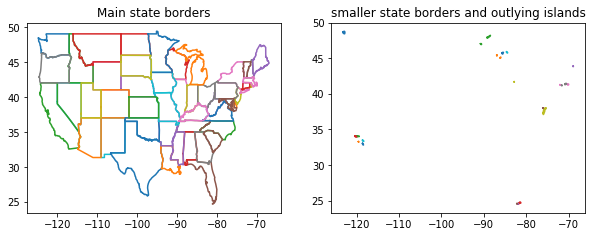

In [16]:
state_border = {}
minor_borders = {}
fig, axes = plt.subplots(1,2,figsize=(10,3.5))
for st,borders in cdf[['STUSPS','geometry']].itertuples(index=False):
    poly = []
    if borders.geom_type == 'MultiPolygon':
        for pol in borders:
            poly.append(pol)
    else:
        poly.append(borders)
    main_pol = max( poly, key= lambda x: x.area)
    
    state_border[st] = main_pol.exterior.coords.xy
    minor_borders[st] = []
    for pol in poly:
        if pol != main_pol: minor_borders[st].append(pol.exterior.coords.xy)

# Re-unite Michigan upper peninsula:
# find closest coordinate pairs between main MI and upper MI
closest = sorted([[p1,p2, (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 ]  for p1 in zip(*state_border['MI']) for p2 in zip(*minor_borders['MI'][4])], key =lambda x: x[-1])[0]
x0=np.where(np.array(state_border['MI']).T == closest[0])[0][0]
x1=np.where(np.array(minor_borders['MI'][4]).T == closest[1])[0][0]
# reorder the coordinates
cc1 = zip(*map(lambda x: np.roll(x, -x0), state_border['MI']))
cc2 = zip(*map(lambda x: np.roll(x, -x1), minor_borders['MI'][4]))
# redefine MI border with both pieces
state_border['MI'] = zip(*(cc1+cc2))
minor_borders['MI'].pop(4)

for st in state_border.keys():
    axes[0].plot(*state_border[st])
    for pol in minor_borders[st]:
        axes[1].plot(*pol)
axes[0].set_title('Main state borders')
axes[1].set_title('smaller state borders and outlying islands');

### aside: test morphing concept on state border map

The concept for deforming a map is simple. 

We will generate a map where the radial distance from one point is given by the travel time instead of the physical distance. Given a map, change the radial distance of each feature according to an input function while keeping the same angle with respect to the origin.

In [17]:
def morph0(pp, p0, func, proj=True):
    """
    Input should be (x,y) projection coordinates (or (lon,lat) pair) if proj==True, or (lat,lon) pairs otherwise.
    """
    (dy, dx) = (pp[1]-p0[1], pp[0]-p0[0]) if proj else (pp[0]-p0[0],pp[1]-p0[1])
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)
    new_r = func(pp) # new radius
    return [new_r*np.cos(theta), new_r*np.sin(theta)]

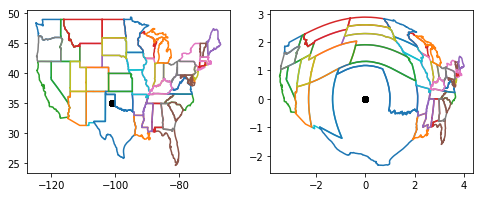

In [18]:
p0= (-101,35)
fig,axes =plt.subplots(1,2,figsize=(8,3))
for st in state_border.keys():
    axes[0].plot(*state_border[st])
    axes[0].scatter(*p0,c='k')
    mbo = [morph0(pp, p0, lambda pp: np.sqrt((p0[1]-pp[1])**2+(p0[0]-pp[0])**2)**0.4, proj=True) for pp in zip(*state_border[st])]
    axes[1].plot(*zip(*mbo))
    axes[1].scatter(0,0,c='k')

## import roads

Rout types are: C: county, I: interstate, M: Common Name (??), O:other, S:state recognized, U: US route (e.g. route 66)

In [22]:
import geopandas as gpd
hwydf = gpd.GeoDataFrame.from_file('../input/tl_2016_us_primaryroads.dbf')
hwydf.head()
# hwydf[hwydf['RTTYP']=='M'].head()

,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,1105647111403,Morgan Branch Dr,M,S1100,"LINESTRING (-75.61562299999999 38.625174, -75...."
1,1103662626368,Biddle Pike,M,S1100,"LINESTRING (-84.56701699999999 38.360526, -84...."
2,1103662626717,Cincinnati Pike,M,S1100,"LINESTRING (-84.568051 38.348926, -84.56800899..."
3,1105056901124,I- 405,I,S1100,"LINESTRING (-122.679601 45.54082199999999, -12..."
4,1105056901128,I- 405,I,S1100,"LINESTRING (-122.670959 45.506849, -122.671025..."


### aside: visualize effect of dropping points

In [129]:
x_range = (-119,-117)
y_range = (32,35)
roads_long = []
for i, hwy in hwydf[hwydf['RTTYP']=='I'].iterrows(): 
    tmp = list(hwy['geometry'].coords)
    # will only check segments that are within the state
    if krm.is_in_range(tmp[0],x_range,y_range) or krm.is_in_range(tmp[-1],x_range,y_range):
        roads_long.append([hwy['FULLNAME'], tmp])
len(roads_long)

114

These roads are incredibly well specified. For our purposes, we can drop a lot of intermediate points, as they will not show up on a map

In [132]:
roads = []
for name, road in roads_long:
    if len(road)<10: nn=1
    elif len(road)<30: nn=len(road)/10
    else: nn=len(road)/20
    roads.append([name,road[::nn]]) 

[87235, 6068]


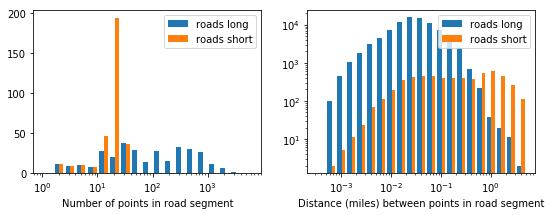

In [35]:
print map(sum,[[len(road) for name, road in roads_long], [len(road) for name, road in roads]])
delta_list = [ krm.get_distance(reversed(road[i]),reversed(road[i+1])) for name, road in roads_long for i in range(len(road)-1)]
delta_list1 = [ krm.get_distance(reversed(road[i]),reversed(road[i+1])) for name, road in roads for i in range(len(road)-1)]

fig, axes=plt.subplots(1,2,figsize=(9,3))
axes[0].hist([[len(road) for name, road in roads_long ],[len(road) for name, road in roads]],  
               histtype='bar', bins=10**np.arange(0,4,0.2))
axes[0].set_xlabel('Number of points in road segment')

axes[1].hist([delta_list, delta_list1], log=True, histtype='bar', bins=10**np.arange(-3.5,0.8,0.2))
axes[1].set_xlabel('Distance (miles) between points in road segment')
for ax in axes: 
    ax.set_xscale('log')
    ax.legend(('roads long','roads short'),loc='upper right', bbox_to_anchor=(1,1));

[87235, 6068]


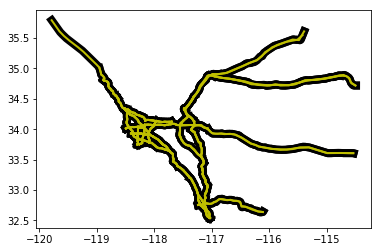

In [49]:
print map(sum, [[len(road) for name, road in roads_long], [len(road) for name, road in roads]] )

for name, road in roads_long:
    _=plt.plot(*np.array(road).T, c='k', lw=8)
for name, road in roads:
    _=plt.plot(*np.array(road).T, c='y', lw=2)
# plt.gca().set(xlim=[-119,-117],ylim=[32.5,34.8]);

## import cities

In [37]:
import geonamescache
gc = geonamescache.GeonamesCache()
cities_us = [gc.get_cities()[ci] for ci in gc.get_cities().keys() if gc.get_cities()[ci]['countrycode']=='US']

In [38]:
cities_us[:2]

[{u'countrycode': u'US',
  u'geonameid': 4479946,
  u'latitude': 34.98543,
  u'longitude': -80.54951,
  u'name': u'Monroe',
  u'population': 34623,
  u'timezone': u'America/New_York'},
 {u'countrycode': u'US',
  u'geonameid': 4794531,
  u'latitude': 38.71678,
  u'longitude': -77.13276,
  u'name': u'Woodlawn',
  u'population': 20804,
  u'timezone': u'America/New_York'}]

### aside: test city label automatic placement

number of cities in US: 3233


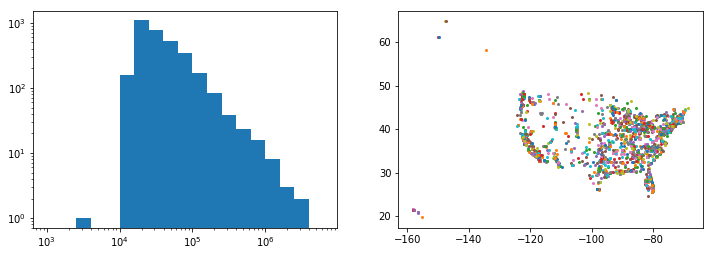

In [43]:
print 'number of cities in US:', len(cities_us)
fig, axes = plt.subplots(1,2, figsize=(12,4)) 
axes[0].hist([ci['population'] for ci in cities_us],bins=10**np.arange(3,7,0.2))
axes[0].set(xscale= 'log', yscale='log')
for ci in cities_us:
    axes[1].scatter(ci['longitude'],ci['latitude'],s=4)

In [52]:
x_range = (-120.5,-115)
y_range = (32,36)
cities = sorted([ ci for ci in cities_us if krm.is_in_range([ci['longitude'], ci['latitude']],x_range, y_range)], key = lambda ci: ci['population'], reverse=True)
print 'number of cities in Los Angeles area:', len(cities) 

number of cities in Los Angeles area: 258


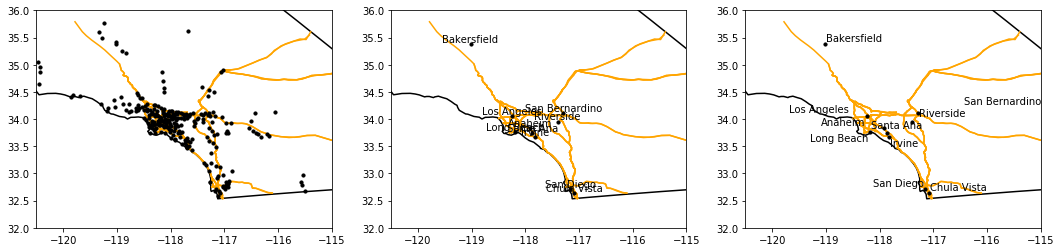

In [58]:
fig, axes = plt.subplots(1,3,figsize=(18,4))
for ax in axes:
    ax.plot(*state_border['CA'],c='k')
    ax.set(xlim=x_range, ylim=y_range)
    for name, road in roads:
        ax.plot(*np.array(road).T, c='orange')

for ci in cities:
    axes[0].scatter(ci['longitude'],ci['latitude'],c='k',s=10,zorder=100)
for ci in cities[:10]:
    axes[1].scatter(ci['longitude'],ci['latitude'],c='k',s=10,zorder=100)
    axes[1].text(ci['longitude'],ci['latitude'],ci['name'],ha='center',va='bottom')
text =[]
for ci in cities[:10]:
    axes[2].scatter(ci['longitude'],ci['latitude'],c='k',s=10,zorder=100)
    text.append(axes[2].text(ci['longitude'],ci['latitude'],ci['name'],ha='center'))
adjust_text(text, ax =axes[2]);

Above, the first panel shows all the named cities in the Los Angeles areas. We clearly cannot write labels for all of them.   
Even with a very simple dataset (middle panel, for the 10 biggest cities), the map is nearly unreadable, as the labels overlap.    
There are two problems here: 1) there are too many closeby cities 2) the labels can overlap even if cities are relatively far away (depending on string length)

The problem of automatic label placement is actually really hard (NP complete), but luckily people have written algorithms in Python, notably `adjust_text` from https://github.com/Phlya/adjustText, and `Dymo` from https://github.com/migurski/Dymo. In the third panel, we use the `adjust_text` as it is relatively simple to use and powerful enough.

For the first problem, we have to decide which cities to show on a map.

We will iteratively cluster the cities: if two cities are close than a certain cutoff, we define the bigger city to be a metro area, with dictionary entries 'metropop' and 'metronames', and put the smaller city into the metro dictionary. If a city has no neighbors, itis its own metro area, while all the cities without 'metro*' keys have been absorbed somewhere else.

In [60]:
cities = [[ci['longitude'],ci['latitude'],ci['name'],ci['population']] for ci in 
          sorted([ ci for ci in cities_us if krm.is_in_range([ci['longitude'], ci['latitude']],x_range, y_range)]
                 , key = lambda ci: ci['population'], reverse=True) ]

citiesZ = [[ci['longitude'],ci['latitude'],ci['name'],ci['population']] for ci in 
          sorted([ ci for ci in cities_us if krm.is_in_range([ci['longitude'], ci['latitude']],(-118.4,-117.1), (33.3,34.15))]
                 , key = lambda ci: ci['population'], reverse=True) ]

In [61]:
cities, citiesZ = cluster_cities(cities), cluster_cities(citiesZ, 11)
cities_plot, cities_plotZ = [ci for ci in cities if len(ci)>4], [ci for ci in citiesZ if len(ci)>4]

map(len,[cities, cities_plot, citiesZ, cities_plotZ])

[258, 22, 148, 16]

Test the result: the red dots are all the cities in the database, and the only cities showing as black dots are the largest in their surroundings. We can also see how the labels are relatively well spaced away from each other

In [35]:
# pos0 = [33.6404952, -117.8442962]

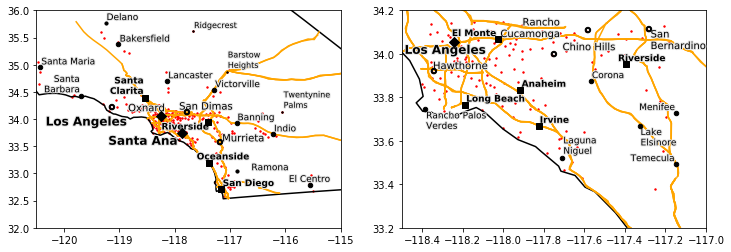

In [71]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
for iax, ax in enumerate(axes):
    ax.plot(*state_border['CA'],c='k')
    ax.set(xlim=[x_range,(-118.5,-117)][iax], ylim=[y_range,(33.2,34.2)][iax])
    for name, road in roads:
        ax.plot(*np.array(road).T, c='orange')
    for ci in [cities_plot, cities_plotZ][iax]:
        ax.scatter(ci[0],ci[1],c='k',zorder=100,**map_point_style(ci[-1]))
    texts = [ ax.text(ci[0],ci[1],reformat_name(ci[2]),ha='center',**map_font_style(ci[-1])) for ci in [cities_plot, cities_plotZ][iax]]
    for ci in [cities,citiesZ][iax]:
        ax.scatter(ci[0],ci[1],c='r',s=2)
    for txt in texts: 
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='0.9')])
    
    adjust_text(texts, ax=ax,expand_objects=(1.02,1.05))
    


Not too bad! Even in the left panel (22 cities plotted), most labels are near their markers. The right panel (16 cities) looks even better.    
Later we will plot about 20-30 cities at a time (our figures will be larger than these so they cna fit more labels).

# chronomaps: morph images according to travel times

### aside: interpolation routines

In [73]:
npzinput = np.load('data/grid_LA.npz')
grid = npzinput['grid']
dists = npzinput['dists']
times = npzinput['times']

city = [ci for ci in cities_us if ci['name']=='Irvine'][0]
pos0 = [city['latitude'], city['longitude']]
p0=[pos0[1],pos0[0]]

In [74]:
x_range = (-120.5,-115)
y_range = (32,36)
# cities = [ ci for ci in cities_us if is_in_range([ci['longitude'], ci['latitude']],x_range, y_range)]

In [75]:
y,x = zip(*grid)
z = np.array(times)/60. #minutes
xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
zz = np.array(krm.smoothen2d(xx,yy,zz)[-1]) # average nearest neighbors
levels=range(0,270,30)

In [76]:
LL , UR = (min(xx), min(yy)), (max(xx), max(yy))
themap = Basemap(llcrnrlon=LL[0],llcrnrlat=LL[1],urcrnrlon=UR[0],urcrnrlat=UR[1], epsg=2229, resolution='i')

In [77]:
from scipy.interpolate import interp2d, NearestNDInterpolator, LinearNDInterpolator, Rbf

In [78]:
func1 = interp2d(xx,yy,zz)
func2 = NearestNDInterpolator(zip(xx,yy),zz)
func3 = LinearNDInterpolator(zip(xx,yy),zz)
func4 = Rbf(xx,yy,zz, function='linear')
func5 = Rbf(xx,yy,zz)


/Users/dio/conda/envs/mapping/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=28,27 m=646 fp=1032.337843 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


The warning message comes from func5, Rbf with default arguments. We will not use it later on.   
There is some spread in the output of the interpolating function depending on the interpolation method used:

In [80]:
map(lambda f: int(f(-118,35)), [func1, func2, func3, func4, func5])

[216, 150, 141, 142, 142]

interp2d seems way off, but the other three methods seem comparable... See what happens trying to plot the CA border (this includes points very far away, for which we bascially have no data, where it is just extrapolating). As one sees, the default Rbf (multiquadric) goes completely crazy in areas where we would expect it to agree with all the other interpolation methods. Linear Rbf instead looks ok

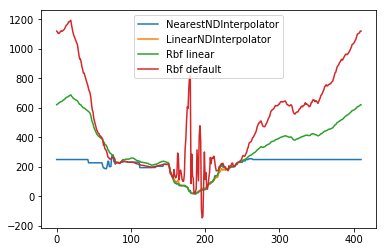

In [81]:
plt.plot([[func2(*pp),func3(*pp),func4(*pp), func5(*pp)] for pp in zip(*state_border['CA'])[:]])
plt.legend(('NearestNDInterpolator', 'LinearNDInterpolator', 'Rbf linear','Rbf default'),loc='upper center');

We here plot fixed travel time contours on a standard map. For making a chronomap, we will change the radial distance of each point as given by the interpolating functions defined above

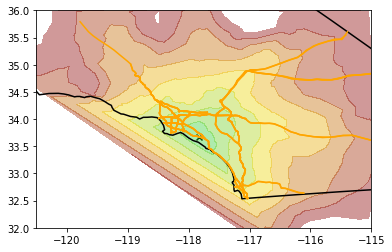

In [82]:
fig,ax = plt.subplots()
for iax in [0]:
    ax.scatter(pos0[1],pos0[0], c='k', marker='x')
    ax.plot(*state_border['CA'],c='k')
    ax.set(xlim=x_range, ylim=y_range)
    for name, road in roads:
        ax.plot(*np.array(road).T, c='orange')
    ax.tricontourf(xx,yy, zz, levels=levels, colors=[cmap(1.2*lev/levels[-1]) for lev in levels], alpha =0.4)

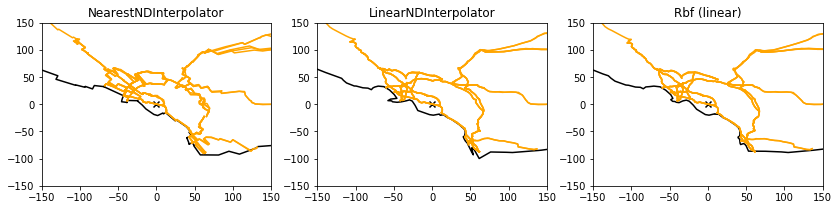

In [83]:
fig,axes = plt.subplots(1,3,figsize=(14,3))
lim = 150
for iax, ax in enumerate(axes):
    ff= [lambda  pp: func2(*pp), lambda  pp: func3(*pp), lambda  pp: func4(*pp)][iax]
    ax.scatter(0,0, c='k', marker='x')
    mbo = [morph0(pp, p0, ff, proj=True) for pp in zip(*state_border['CA'])]
    ax.plot(*zip(*mbo),c='k')
    ax.set(xlim=(-lim,lim), ylim=(-lim,lim), title=['NearestNDInterpolator','LinearNDInterpolator', 'Rbf (linear)'][iax])
    for name, road in roads:
        mro = [morph0(pp, p0, ff, proj=True) for pp in road]
        ax.plot(*zip(*mro), c='orange')


Use Rbf linear as it is the less noisy function. LinearNDInterpolator would give very similar results, but it is a little more "spiky" for points near the coast, where there is no data for points in the ocean and its extrapolation is more wild.

In [84]:
def time_func(pp):
    res = func4(*pp)
    return res

In [85]:
def morph(pp, p0, func, projmap=''):
    """
    Input should be (lon,lat) coordinates. If projmap='', compute angles between (lon,lat) points, otherwise 
    between projection coordinate points defined by the projection map passed in input.
    """
    (dy, dx) = (pp[1]-p0[1], pp[0]-p0[0]) if projmap=='' else (projmap(*pp)[1]-projmap(*p0)[1], projmap(*pp)[0]-projmap(*p0)[0])
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)
    new_r = func(pp) # new radius
    return [new_r*np.cos(theta), new_r*np.sin(theta)]

Notice that there is some difference if for the input we take lat,lon coordinates or projection coordinates. As we are interested to see how a map changes, we will make a chronomap starting from projection coordinates, but it is good to be aware of the starting layer.

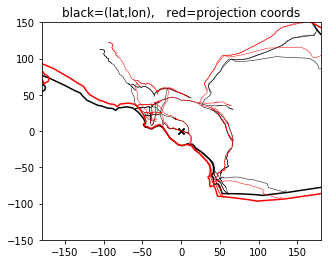

In [86]:
fig,ax = plt.subplots(1,1,figsize=(5,4))

lim = 150
for iax in [0,1]:
    ax.scatter(0,0, c='k', marker='x')
    mbo = [morph(pp, p0, time_func, projmap=['',themap][iax]) for pp in zip(*state_border['CA'])]
    ax.plot(*zip(*mbo),c=['k','r'][iax])
    ax.set(xlim=(-1.2*lim,1.2*lim), ylim=(-lim,lim))
    for name, road in roads[::3]:
        mro = [morph(pp, p0, time_func, projmap=['',themap][iax]) for pp in road]
        ax.plot(*zip(*mro), c=['k','r'][iax],lw=.5)
ax.set_title('black=(lat,lon),   red=projection coords');

## make chronomaps

In [87]:
def morph(pp, p0, func, projmap=''):
    """
    Input should be (lon,lat) coordinates. If projmap='', compute angles between (lon,lat) points, otherwise 
    between projection coordinate points defined by the projection map passed in input.
    """
    (dy, dx) = (pp[1]-p0[1], pp[0]-p0[0]) if projmap=='' else (projmap(*pp)[1]-projmap(*p0)[1], projmap(*pp)[0]-projmap(*p0)[0])
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)
    new_r = func(pp) # new radius
    return np.array([new_r*np.cos(theta), new_r*np.sin(theta)])

In [163]:
npzinput = np.load('data/grid_LA.npz')
grid = npzinput['grid']
dists = npzinput['dists']
times = npzinput['times']
pos0 = grid[0] #[33.6404952, -117.8442962]
p0=[pos0[1],pos0[0]]

In [164]:
y,x = zip(*grid)
z = np.array(times)/60. #minutes
xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
zz = np.array(krm.smoothen2d(xx,yy,zz)[-1])
zz[0] = 0. # set origin to 0 - otherwise I have averaged with nearby points...
levels=range(0,270,30)

In [165]:
x_range,y_range = map(lambda f: f(xx),[min,max]), map(lambda f: f(yy),[min,max])
roads_long = []
for i, hwy in hwydf.iterrows(): 
    tmp = list(hwy['geometry'].coords)
    # will only check segments that are within the state
    if krm.is_in_range(tmp[0],x_range,y_range) or krm.is_in_range(tmp[-1],x_range,y_range):
        roads_long.append([hwy['FULLNAME'], tmp])
len(roads_long)

350

In [166]:
roads = []
for name, road in roads_long:
    if len(road)<10: nn=1
    elif len(road)<30: nn=len(road)/10
    else: nn=len(road)/20
    roads.append([name,road[::nn]+[road[-1]]])  

In [93]:
themap = Basemap(llcrnrlon=min(x),llcrnrlat=min(y),urcrnrlon=max(x),urcrnrlat=max(y), epsg=2229, resolution='i')
themap0= Basemap(llcrnrlon=min(x),llcrnrlat=min(y),urcrnrlon=max(x),urcrnrlat=max(y), projection='cyl', resolution='h')

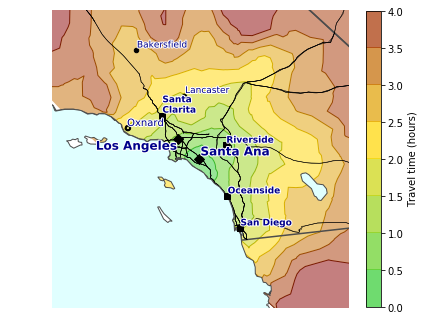

In [100]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax = make_contour_map(xx,yy,zz, ax, themap, p0, levels=levels, plot_cities=True, plot_roads=True, roads=roads, plot_water=True, dist_cut=30, n_cities_cut=10)

In [640]:
fig.subplots_adjust(left=0., right=.9, top=1, bottom=0)
fig.savefig('figs/travel_times_Irvine.png')

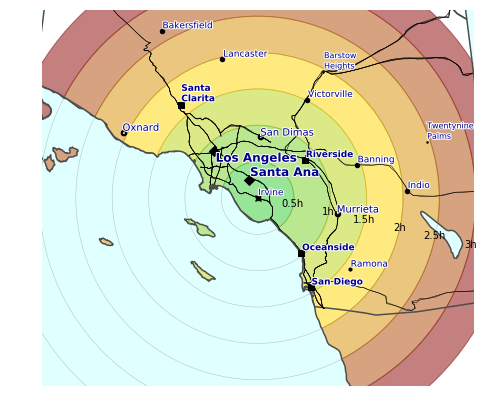

In [106]:
# %%time
fig,ax = plt.subplots(1,1,figsize=(6,6))
fig.subplots_adjust(left=0., right=1, top=1, bottom=0)
ax = make_chronomap(xx,yy,zz, ax, [themap,themap0], p0, levels=range(0,210,30), plot_cities=True, plot_roads=True, roads=roads, plot_water=True, water_lw=1.5, zorder_water=3 , theta=-13, cbarlabel='hours' )

In [107]:
fig.savefig('figs/chronomap_Irvine.png')

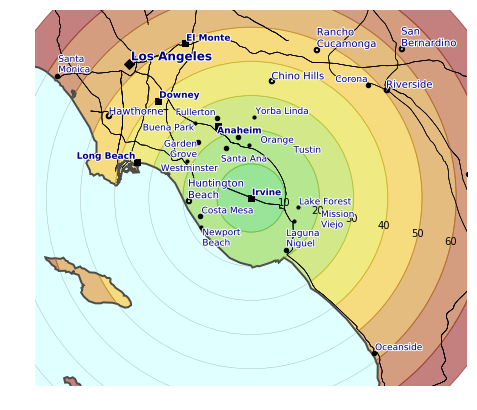

In [137]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
fig.subplots_adjust(left=0., right=1, top=1, bottom=0)
ax = make_chronomap(xx,yy,zz, ax, [themap,themap0], p0, levels=range(0,71,10), lim=55, plot_cities=True, dist_cut=10, n_cities_cut=30,
                   small_city_radius=30, plot_roads=True, roads=roads_long, plot_water=True, water_lw=2, plot_states=False, theta=-13, cbarlabel='minutes' )

In [138]:
fig.savefig('figs/chronomap_Irvine_zoom.png')

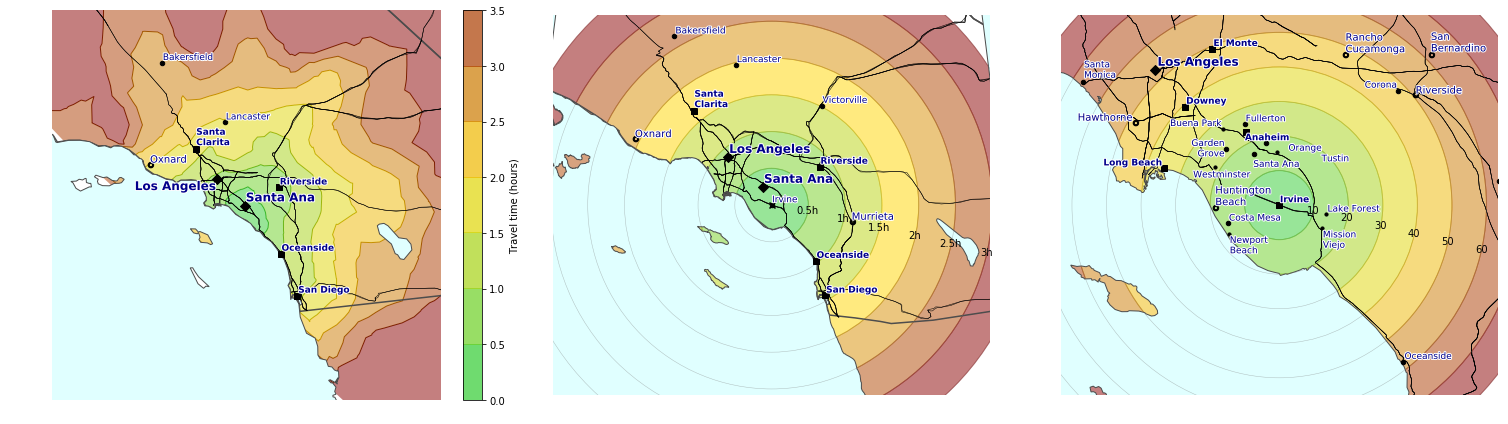

In [139]:
fig,axes = plt.subplots(1,3,figsize=(21.2,6))
plot_roads, plot_water = True, True
axes[0] = make_contour_map(xx,yy,zz, axes[0], themap, p0, levels=range(0,240,30), plot_cities=True, plot_roads=plot_roads, roads=roads, plot_water=plot_water, dist_cut=30, n_cities_cut=10)
axes[1] = make_chronomap(xx,yy,zz, axes[1], [themap,themap0], p0, levels=range(0,210,30), plot_cities=True, n_cities_cut=12, plot_roads=plot_roads, roads=roads, plot_water=plot_water, water_lw=1, zorder_water=3 , theta=-13, cbarlabel='hours' )
axes[2] = make_chronomap(xx,yy,zz, axes[2], [themap,themap0], p0, levels=range(0,71,10), lim=55, plot_cities=True, dist_cut=10, n_cities_cut=27,
                   small_city_radius=30, plot_roads=plot_roads, roads=roads_long, plot_water=plot_water, water_lw=1, plot_states=False, theta=-13, cbarlabel='minutes' )

In [141]:
fig.subplots_adjust(left=0., right=1, top=0.98, bottom=0.02, wspace=0.1)
fig.savefig('figs/chronomap_Irvine_combined0.png')

Jump to [Animations](#Animations)

# chronomaps for other US cities

In [149]:
cities_list = ['San Francisco', 'Seattle', 'Denver', 'Chicago', 'Washington, D.C.', 'New York City']
pos0_list=[]
for name in cities_list:
    city = [ci for ci in cities_us if name == ci['name']][0]
    pos0_list.append([city['latitude'], city['longitude']])
short_name_list = ['SF','Sea','Den','Chi','DC','NY']
epsg_list = [2226, 2285, 2773, 3435, 2248, 2263]

In [150]:
grid_list, dists_list, times_list = [], [], []
pos0_list=[]

for idx in range(len(cities_list)):
    npzinput = np.load('data/grid_'+short_name_list[idx]+'.npz')
    grid_list.append(npzinput['grid'])
    dists_list.append(npzinput['dists'])
    times_list.append(npzinput['times'])
    pos0_list.append(grid_list[idx][0])

In [151]:
roads_list, roads_long_list = [], []
for idx in range(len(cities_list)):
    y, x = zip(*grid_list[idx])
    z = np.array(times_list[idx])/60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
    
    roads_long1 = []
    x_range,y_range = map(lambda f: f(xx),[min,max]), map(lambda f: f(yy),[min,max])
    for i, hwy in hwydf.iterrows(): 
        tmp = list(hwy['geometry'].coords)
        # will only check segments that are within the state
        if krm.is_in_range(tmp[0],x_range,y_range) or krm.is_in_range(tmp[-1],x_range,y_range):
            roads_long1.append([hwy['FULLNAME'], tmp])
    roads_long_list.append(roads_long1)

    roads1 = []
    for name, road in roads_long1:
        if len(road)<10: nn=1
        elif len(road)<30: nn=len(road)/5
        else: nn=len(road)/30
        roads1.append([name, road[::nn]+[road[-1]]])     
    roads_list.append(roads1)

[len(r) for r in roads_list]

[252, 230, 351, 1191, 1685, 2044]

Load projection maps in memory so it does not slow down execution later (this takes a while to load hi-res maps)

In [152]:
%%time
themap_list = []
themap0_list = []
for idx in range(len(cities_list)):
    tmpgrid = grid_list[idx]
    y, x = zip(*tmpgrid)
    themap_list.append(Basemap(llcrnrlon=min(x),llcrnrlat=min(y),urcrnrlon=max(x),urcrnrlat=max(y), epsg=epsg_list[idx], resolution='i'))
    themap0_list.append(Basemap(llcrnrlon=min(x),llcrnrlat=min(y),urcrnrlon=max(x),urcrnrlat=max(y), projection='cyl', resolution='h'))

CPU times: user 3min 14s, sys: 5.1 s, total: 3min 19s
Wall time: 3min 42s


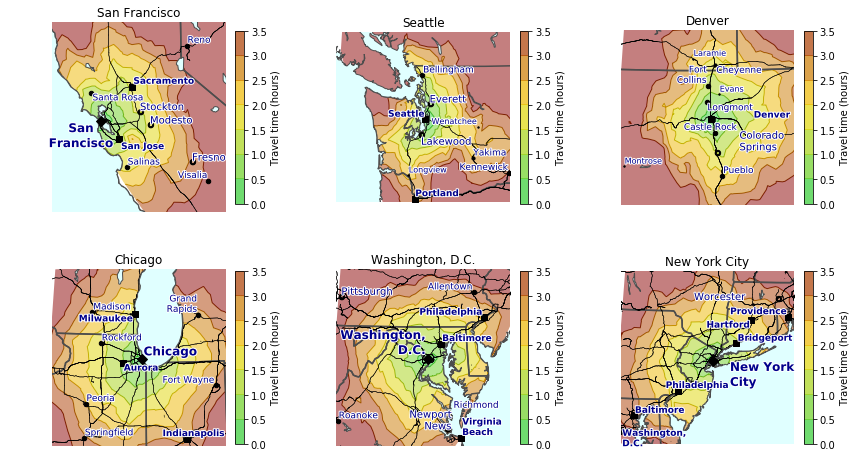

In [153]:
fig, axes = plt.subplots(2,3,figsize=(12,7))
levels=range(0,210+1,30)

for idx in range(len(cities_list)):
    ax = axes[idx//3][idx%3]
    ax.set(title=cities_list[idx], adjustable='box')
    
    y, x = zip(*grid_list[idx])
    z = np.array(times_list[idx])/60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,5)[-1])

    themap = themap_list[idx]
    p0 = list(reversed(pos0_list[idx]))
    ax = make_contour_map(xx,yy,zz, ax, themap, p0, levels=levels, plot_cities=True, plot_roads=True, roads=roads_list[idx], plot_water=True, dist_cut=30, n_cities_cut=10)

In [155]:
fig.subplots_adjust(left=0.02, right=0.95, top=0.95, bottom=0.02, wspace=0.17, hspace=0.1)
fig.savefig('figs/grid_cities_travel_times.png')

Save the individual figures...

In [156]:
dist_cut_list=[15,17,13,17,15,15]
for idx in range(len(cities_list)):
    fig, ax = plt.subplots(figsize=(6,6))
    #ax.set_title(cities_list[idx])
    
    y, x = zip(*grid_list[idx])
    z = np.array(times_list[idx])/60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,5)[-1])

    themap = themap_list[idx]
    dist_cut=dist_cut_list[idx]
    p0 = list(reversed(pos0_list[idx]))
    
    ax = make_contour_map(xx,yy,zz, ax, themap, p0, levels=levels, plot_cities=True, plot_roads=True, roads=roads_list[idx], plot_water=True, dist_cut=dist_cut, n_cities_cut=20)
    fig.savefig('figs/travel_times_'+short_name_list[idx]+'.png')
    plt.close()

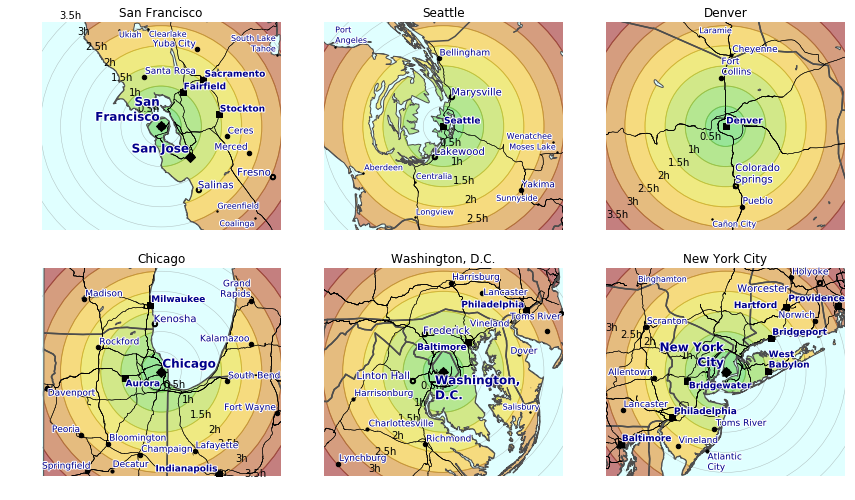

In [157]:
fig, axes = plt.subplots(2,3,figsize=(12,7))
fig.subplots_adjust(left=0.02, right=0.95, top=0.95, bottom=0.02, wspace=0.18, hspace=0.1)
levels=range(0,210+1,30)
dist_cut_list=[15,17,13,17,15,15]
th0_list=[130,-70,-140,-48,-125,160]

for idx in range(len(cities_list)):
    ax = axes[idx//3][idx%3]
    ax.set_title(cities_list[idx])
    
    y, x = zip(*grid_list[idx])
    z = np.array(times_list[idx])/60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,9)[-1])
    zz[0]=0.

    themap = themap_list[idx]
    themap0 = themap0_list[idx]
    th0 = th0_list[idx]
    p0 = list(reversed(pos0_list[idx]))
    ax = make_chronomap(xx,yy,zz, ax, [themap,themap0], p0, levels=levels, plot_cities=True, plot_roads=True,
                       roads=roads_list[idx], plot_water=True, dist_cut=30, theta=th0)

In [158]:
fig.savefig('figs/grid_cities_chronomaps0.png',dpi=120)

In [159]:
cbarlabel='Travel time (hours)'
levels=range(0,210+1,30)
dist_cut_list=[14,17,13,17,15,15]

for idx in range(len(cities_list)):
    fig, ax = plt.subplots(figsize=(6,6))
    fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.0)

    y, x = zip(*grid_list[idx])
    z = np.array(times_list[idx])/60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,5)[-1])
    zz[0]=0.

    p0 = list(reversed(pos0_list[idx]))
    themap = themap_list[idx]
    themap0 = themap0_list[idx]
    dist_cut=dist_cut_list[idx]
    th0 = th0_list[idx]
    ax = make_chronomap(xx,yy,zz, ax, [themap,themap0], p0, levels=levels, plot_cities=True, n_cities_cut=30, plot_roads=True, roads=roads_list[idx], plot_water=True, dist_cut=dist_cut, theta=th0)

    fig.savefig('figs/chronomap_'+short_name_list[idx]+'.png')
    plt.close()

Now zoom in into one-hour range for each city. Repeat same cells as above, but change lim and levels

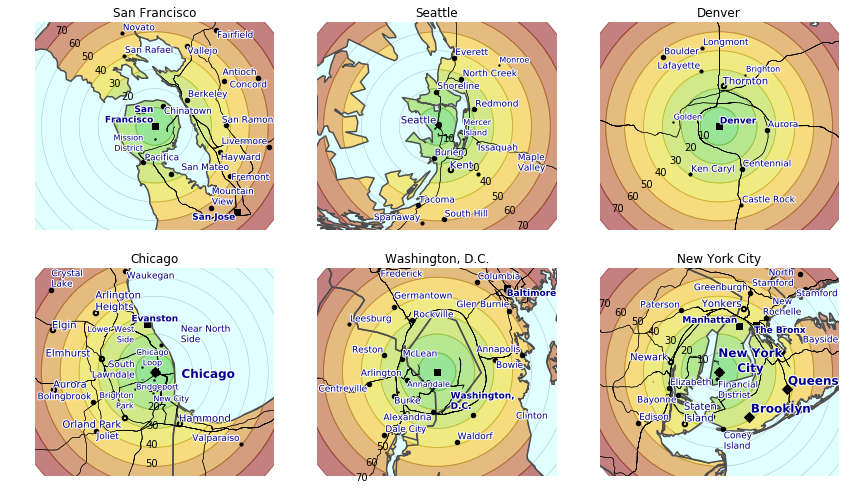

In [160]:
fig, axes = plt.subplots(2,3,figsize=(12,7))
fig.subplots_adjust(left=0.02, right=0.95, top=0.95, bottom=0.02, wspace=0.18, hspace=0.1)
levels=range(0,210+1,30)
dist_cut_list=[9,8,8,12,8,5]
th0_list=[135,-50,-140,-92,-125,150]
small_r_list=[15,16,17.5,15,25,10]

# for idx in [3]:
for idx in range(len(cities_list)):
    ax = axes[idx//3][idx%3]
    ax.set_title(cities_list[idx])
    
    y, x = zip(*grid_list[idx])
    z = np.array(times_list[idx])/60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,9)[-1])
    zz[0]=0.

    themap = themap_list[idx]
    themap0 = themap0_list[idx]
    th0 = th0_list[idx]
    p0 = list(reversed(pos0_list[idx]))
    
    ax = make_chronomap(xx,yy,zz, ax, [themap,themap0], p0, levels=range(0,71,10), lim=55, plot_roads=True, roads=roads_list[idx], plot_states=idx//3,
                       plot_cities=True,dist_cut=dist_cut_list[idx], small_city_radius=small_r_list[idx], plot_water=True, water_lw=1.5,  theta=th0, cbarlabel='minutes' )

In [267]:
fig.savefig('figs/grid_cities_chronomaps_zoom.png',dpi=150)

In [161]:
# for idx in [5]:
for idx in range(len(cities_list)):
    fig, ax = plt.subplots(figsize=(6,6))
    fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.0)
    ax.set_title(cities_list[idx])
    
    y, x = zip(*grid_list[idx])
    z = np.array(times_list[idx])/60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,5)[-1])
    zz[0]=0.

    themap = themap_list[idx]
    themap0 = themap0_list[idx]
    th0 = th0_list[idx]
    p0 = list(reversed(pos0_list[idx]))
    
    ax = make_chronomap(xx,yy,zz, ax, [themap,themap0], p0, levels=range(0,71,10), lim=55, plot_roads=True, roads=roads_list[idx], plot_states=idx//3,
                       plot_cities=True,dist_cut=dist_cut_list[idx], small_city_radius=50, plot_water=True, water_lw=1.5, theta=th0, cbarlabel='minutes' )
    fig.savefig('figs/chronomap_'+short_name_list[idx]+'_zoom.png')
    plt.close()

In [162]:
# for idx in [0]:
for idx in range(len(cities_list)):
    fig,axes = plt.subplots(1,3,figsize=(21.2,6))
    fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.0)
    ax.set_title(cities_list[idx])
    
    y, x = zip(*grid_list[idx])
    z = np.array(times_list[idx])/60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,5)[-1])
    zz[0]=0.

    themap = themap_list[idx]
    themap0 = themap0_list[idx]
    th0 = th0_list[idx]
    p0 = list(reversed(pos0_list[idx]))
    
    plot_roads, plot_water = True, True
    axes[0] = make_contour_map(xx,yy,zz, axes[0], themap, p0, levels=levels, plot_cities=True, plot_roads=plot_roads, roads=roads_list[idx], plot_water=True, dist_cut=dist_cut, n_cities_cut=20)
    axes[1] = make_chronomap(xx,yy,zz, axes[1], [themap,themap0], p0, levels=levels, plot_cities=True, n_cities_cut=30, plot_roads=plot_roads, roads=roads_list[idx], plot_water=True, dist_cut=dist_cut, theta=th0)
    axes[2] = make_chronomap(xx,yy,zz, axes[2], [themap,themap0], p0, levels=range(0,71,10), lim=55, plot_roads=plot_roads, roads=roads_list[idx], plot_states=idx//3,
                       plot_cities=True,dist_cut=dist_cut_list[idx], small_city_radius=30, n_cities_cut=25, plot_water=True, water_lw=1.5, theta=th0, cbarlabel='minutes' )
    fig.subplots_adjust(left=0., right=1, top=0.98, bottom=0.02, wspace=0.1)
    fig.savefig('figs/chronomap_'+short_name_list[idx]+'_combined.png')
    plt.close()

# Animations

In this section I will make animations, first of the isochrone map and then of the distortion into the chronomap.

In [227]:
npzinput = np.load('data/grid_LA.npz')
grid = npzinput['grid']
dists = npzinput['dists']
times = npzinput['times']
pos0 = grid[0] #[33.6404952, -117.8442962]
p0=[pos0[1],pos0[0]]

In [228]:
y,x = zip(*grid)
z = np.array(times)/60. #minutes
xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
zz = np.array(krm.smoothen2d(xx,yy,zz)[-1])
zz[0] = 0. # set origin to 0 - otherwise I have averaged with nearby points...
levels=range(0,270,30)

In [229]:
x_range,y_range = map(lambda f: f(xx),[min,max]), map(lambda f: f(yy),[min,max])
roads_long = []
for i, hwy in hwydf.iterrows(): 
    tmp = list(hwy['geometry'].coords)
    # will only check segments that are within the state
    if krm.is_in_range(tmp[0],x_range,y_range) or krm.is_in_range(tmp[-1],x_range,y_range):
        roads_long.append([hwy['FULLNAME'], tmp])
len(roads_long)

350

In [230]:
roads = []
for name, road in roads_long:
    if len(road)<10: nn=1
    elif len(road)<30: nn=len(road)/10
    else: nn=len(road)/20
    roads.append([name,road[::nn]+[road[-1]]])  

In [231]:
func4 = Rbf(xx,yy,zz, function='linear')

def time_func(pp):
    res = func4(*pp)
    return res

In [232]:
def interp_func(pp, p0, xstep, rescale_rt, projmap=''):
    """
    Function that linearly interpolates between geographical distance and travel time, with xstep in the [0,1] range
    Input argument rescale_rt are the max Euclidean distance and travel time for points in the grid.
    """
    rescale_r, rescale_t = rescale_rt
    pp_time = time_func(pp)/rescale_t
    if projmap != '': pp, p0 = projmap(*pp), projmap(*p0)
    pp_dist = np.sqrt((pp[0]-p0[0])**2+(pp[1]-p0[1])**2)/rescale_r
    return pp_dist*(1.-xstep) + pp_time*xstep

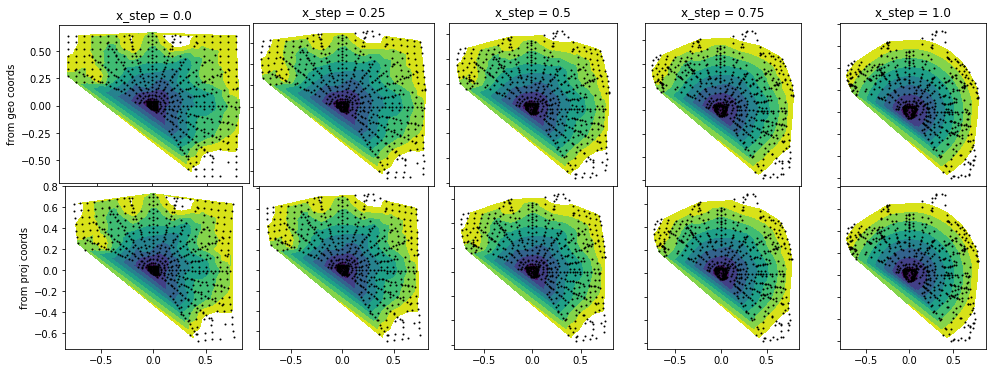

In [233]:
rescale_r = np.sqrt(max([(pp[0]-p0[0])**2+(pp[1]-p0[1])**2 for pp in zip(xx,yy)]))
rescale_t = max([ time_func(pp) for pp in zip(xx,yy)])

fig, axes = plt.subplots(2,5,figsize=(17,6))
for iax, ax in enumerate(axes[0]):
    x1, y1 = zip(*[ morph(pp, p0, lambda pp: interp_func(pp,p0, 1.*iax/(len(axes[0])-1), [rescale_r, rescale_t])) for pp in zip(xx,yy)])
    ax.tricontourf(x1,y1,zz, levels=levels)
    ax.scatter(x1,y1,s=1,c='k')
    ax.set_title('x_step = '+str(1.*iax/(len(axes[0])-1)))
    ax.set_aspect(1)
    if iax>0: ax.set_yticklabels([])

rescale_r = np.sqrt(max([(pp[0]-themap(*p0)[0])**2+(pp[1]-themap(*p0)[1])**2 for pp in zip(*themap(xx,yy))]))
for iax, ax in enumerate(axes[1]):
    x1, y1 = zip(*[ morph(pp, p0, lambda pp: interp_func(pp,p0, 1.*iax/(len(axes[1])-1), [rescale_r, rescale_t], projmap=themap)) for pp in zip(xx,yy)])
    ax.tricontourf(x1,y1,zz, levels=levels)
    ax.scatter(x1,y1,s=1,c='k')
    ax.set_aspect(1)
    if iax>0: ax.set_yticklabels([])
axes[0][0].set(ylabel='from geo coords');
axes[1][0].set(ylabel='from proj coords');
fig.subplots_adjust(wspace=0, hspace=0)

In [174]:
from matplotlib import animation, rc, rcParams
from IPython.display import HTML
rc('animation', html='html5')
rc('animation', embed_limit=200.)

In [206]:
def make_filling_colorbar(ax, pos_cbar, fine_lev, levels, fill_coarse_levels=False):
    dx, dy = 0.03, 0.05
    p_bbox = FancyBboxPatch(pos_cbar, 2*dx, dy*len(levels), boxstyle="round,pad="+str(dx/1.5),ec="gray", fc="0.95", transform=ax.transAxes, zorder=10**3-1)
    ax.add_patch(p_bbox)

    tmp = [ list(fine_levels).index(l) for l in fine_levels if l in levels]
    patch=[]
    cbarlabels=[]
    max_value = levels[-1] + (levels[-1]-levels[-2])    
    for ilev in range(list(fine_levels).index(fine_lev)):
        if fine_levels[ilev] < max_value: 
            col=cmap(1.*fine_levels[ilev]/levels[-1])
            ax.add_patch(Rectangle((pos_cbar[0],pos_cbar[1]+ilev*dy/(tmp[1]-tmp[0])),dx, dy/(tmp[1]-tmp[0]), linewidth=2, edgecolor='none',facecolor=col, alpha=0.7,transform=ax.transAxes, zorder=10**3))
    for ilev,lev in enumerate(levels):
        col = cmap(1.*lev/levels[-1])
        facecolor = col if fill_coarse_levels else 'none'
        col=krm.lighten_color(cmap(1.*lev/levels[-1]),1.2)
        ax.add_patch(Rectangle((pos_cbar[0],pos_cbar[1]+ilev*dy),dx,dy, linewidth=2, edgecolor=col,facecolor=facecolor,zorder=10**3,transform=ax.transAxes))
        if ilev%2==0:
            ax.annotate(str(int(lev/60))+'h',xy=(pos_cbar[0]+1.1*dx,pos_cbar[1]+ilev*dy-dy/5),  xycoords='axes fraction' ,ha='left',zorder=10**3)

    return ax
# can be tested with this:
# fig, ax = plt.subplots()
# ax = make_filling_colorbar(ax, pos_cbar, 150)

I here define three functions:
- `animate_fill(i, ax)` - it makes a standard map (with `World_Physical_Map` ArcGIS background) and fills with color up to travel time defined by `fine_levels[i]`. It also draws all contours in `norm_levels` which are below the currently plotted time. 
- `animate_chronomap(i, ax)` - it draws a map such that when i=0 I get a standard map, when i=morph_steps I get the chronomap, and otherwise I have a linearly interpolated map between the two. Fixed travel time contours are filled according to `norm_levels`.

We then define `animate_all(i)`, defined for `i=-len(fine_levels), ... , 0 , ... , morph_steps`, such that:
- for `i=-len(fine_levels), ... , -1)`, fills the standard map with an increasing blob of color as the travel time increases by calling `animate_fill`
- for `i=0, ... , morph_steps`, transforms the standard map into a chronomap, by calling `animate_chronomap`
- finally, it adds all the recognizable layers such as states, roads, and masks the outside of the US with a white layer. By default roads are not plotted as it takes a while. I will turn it on with plot_roads=True when I want to save the output plots and animations.

In [207]:
def animate_fill(i, ax):
    ax.clear()
    
    themap.arcgisimage(service='World_Physical_Map',xpixels=800, ax = ax)
    #themap.shadedrelief(ax=ax)
    
    xm, ym = themap(xx,yy)
    
    levs = [lev for lev in norm_levels if lev <= fine_levels[i]]
    cols = [cmap(1.*lev/levels[-1]) for lev in levels]
    
    if len(levs)>1: 
        ax.tricontour(xm,ym,zz,levels=levs, colors=map(lambda c: krm.lighten_color(c,1.2), cols[:norm_levels.index(levs[-1])]),linewidths=1)
        ax.tricontourf(xm,ym,zz,levels=fine_levels[:i+1],colors=fine_cols[:i+1], alpha=0.5, antialiased=True)
    txt = ax.annotate('Travel time: '+krm.sec_to_hms(fine_levels[i]*60)[:-2], xy = pos_txt, 
                xycoords='axes fraction', va='bottom',zorder=101)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2.5, foreground='w')])
    
    ax = make_filling_colorbar(ax, pos_cbar, fine_levels[i], norm_levels)
    
    ax.scatter(*themap(pos0[1],pos0[0]), marker='x',c='k', s=20, zorder=100)
    
    # center origin: p0 ± (x_span, y_span)
    if isinstance(x_span, list) and len(x_span)==2: # fix if asymmetrical
        ax.set(xlim=(pm0[0]-x_span[0], pm0[0]+x_span[1] ), ylim=(pm0[1]-y_span, pm0[1]+y_span ))
    else: ax.set(xlim=(pm0[0]-x_span, pm0[0]+x_span ), ylim=(pm0[1]-y_span, pm0[1]+y_span ));
    
    patches = patch_mask_oceans_lakes(themap, ax, aquacolor='lightcyan',zorder=3, lw=1)
    for patch in patches: ax.add_patch(patch)

def animate_chronomap(i, ax):
    ax.clear()
    func = lambda pp: interp_func(pp,p0, 1.*i/morph_steps, [rescale_r, rescale_t], projmap=themap)
    
    # fix origin and span to match with previous frames:
    if isinstance(x_span, list) and len(x_span)==2: # fix if asymmetrical
        ax.set(xlim=(-x_span[0]/rescale_r, x_span[1]/rescale_r), ylim=(-y_span/rescale_r, y_span/rescale_r), aspect=1)
    else: ax.set(xlim=(-x_span/rescale_r, x_span/rescale_r), ylim=(-y_span/rescale_r, y_span/rescale_r), aspect=1)
    
    ax.scatter(0,0, c='k', marker='x',zorder=100)
    
    if i==morph_steps:
        for ilev, lev in enumerate(levels):
            col=cmap(1.*lev/levels[-1])
            dlev = (levels[1]-levels[0])/rescale_t
            lev = lev/rescale_t
            ax.add_patch(Wedge((0,0),lev+dlev,0,360,width=dlev,facecolor=col,edgecolor=col,alpha=0.5))
            ax.add_patch(Circle((0,0),lev+dlev,facecolor='none',edgecolor='gray',zorder=4,lw=0.5,alpha=0.5))

    else:
        mgrid = [ morph(pp, p0, func, projmap=themap) for pp in zip(xx,yy)]
        x1, y1 = zip(*mgrid)
        ax = make_contour_map(x1,y1,zz, ax, '', p0, levels=levels, plot_cities=True, 
                          plot_roads=not True, roads=roads, plot_water=not True, dist_cut=30, n_cities_cut=10, cbarlabel='')

    # add ocean/lake layer: set zorder=0 for the water layer to be under the color rings
    if True: 
        patches = patch_mask_oceans_lakes(themap1, ax, morph_func=lambda pp: morph(pp, p0, func, projmap=themap), zorder=3, lw=1)
        for p in patches: ax.add_patch(p)

    ax = make_filling_colorbar(ax, pos_cbar, fine_levels[i], norm_levels, fill_coarse_levels=True)
    if isinstance(x_span, list) and len(x_span)==2: # fix if asymmetrical
        ax.set(xlim=(-x_span[0]/rescale_r, x_span[1]/rescale_r), ylim=(-y_span/rescale_r, y_span/rescale_r), aspect=1)
    else: ax.set(xlim=(-x_span/rescale_r, x_span/rescale_r), ylim=(-y_span/rescale_r, y_span/rescale_r), aspect=1)
    #if i in [morph_steps]: _=adjust_text(texts, ax=ax)
    
# put it all together
def animate_all(i, ax, plot_roads=False):
    if i >= morph_steps: i = morph_steps # hang on with last frame

    if -len(fine_levels)<= i <0: 
        animate_fill(len(fine_levels)+i, ax)
        func = lambda pp: np.sqrt((themap(*p0)[1]-themap(*pp)[1])**2+(themap(*p0)[0]-themap(*pp)[0])**2)
        projmap = themap
        origin = np.array(themap(*p0))
    elif 0 <= i <= morph_steps:
        animate_chronomap(i, ax)
        func = lambda pp: interp_func(pp, p0, 1.*i/morph_steps, [rescale_r, rescale_t], projmap=themap)
        projmap= themap
        origin =(0,0)
    
    if True:
        states = [st for st in state_border.keys() if any([krm.is_in_range(pp,x_range,y_range,) for pp in zip(*state_border[st])])]
        for st in states:   #morph(pp, p0,     , projmap=themap)
            mbo = [ origin + morph(pp, p0, func,projmap=projmap) for pp in zip(*state_border[st])]
            ax.plot(*zip(*mbo),c='0.3',zorder=2)
    if plot_roads: #plot_roads
        for name, road in roads:
            mbo = [origin + morph(pp, p0, func, projmap=projmap) for pp in road]
            ax.plot(*zip(*mbo), c='k',lw=.5,zorder=2)
    
    if True: #plot_cities
        cities = [[ci['longitude'],ci['latitude'],ci['name'],ci['population']] for ci in 
              sorted([ ci for ci in cities_us if krm.is_in_range([ci['longitude'], ci['latitude']],x_range, y_range)]
                     , key = lambda ci: ci['population'], reverse=True) ]
        cities = cluster_cities(cities)
        cities_plot = [ci for ci in cities if (len(ci)>4 and time_func([ci[0], ci[1]])<levels[-1])]
        texts=[]
        for ci in reversed(cities_plot[:15]):
            mci = origin +  morph([ci[0], ci[1]], p0, func, projmap=projmap) 
            if krm.is_in_range(mci, ax.get_xlim(),ax.get_ylim()):
                ax.scatter(*mci,c='k',zorder=100,**map_point_style(ci[-1]))
                font = map_font_style(ci[-1], extradict={'color':'darkblue'})
                texts.append(ax.text(*mci, s=reformat_name(ci[2]), fontdict=font, zorder=100, ha='center'))
        for txt in texts: txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
    ax.set_axis_off()


In [234]:
rebox = 0.2
themap = Basemap(llcrnrlon=min(xx)+rebox,llcrnrlat=min(yy)+rebox,urcrnrlon=max(xx)-rebox,urcrnrlat=max(yy)-rebox, 
                 epsg=2229, resolution ='i')
rebox=-2
themap1 = Basemap(llcrnrlon=min(xx)+rebox,llcrnrlat=min(yy)+rebox,urcrnrlon=max(xx)-rebox,urcrnrlat=max(yy)-rebox, 
                  projection='cyl', resolution ='i')

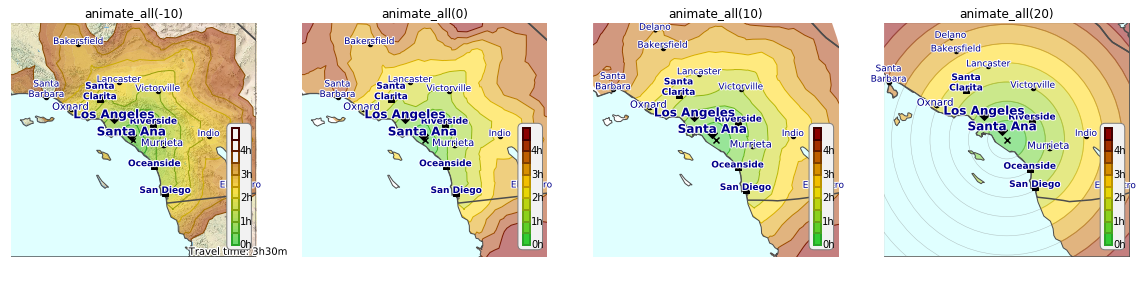

In [237]:
norm_levels = range(0,270+1,30)
fine_levels = np.arange(0,300+1,10)
fine_cols = [cmap(1.2*lev/norm_levels[-1]) for lev in fine_levels]

rebox=0.2
x_range, y_range = map( lambda X: map(lambda i: [min,max][i](X)+rebox*(-1)**i,[0,1]), [xx,yy])
pm0 = themap(*p0) 
x_span = min(map(lambda x: abs(x-pm0[0]), themap(x_range, y_range)[0]))
y_span = min(map(lambda y: abs(y-pm0[1]), themap(x_range, y_range)[1]))

morph_steps = 20
rescale_r = np.sqrt(max([(pp[0]-themap(*p0)[0])**2+(pp[1]-themap(*p0)[1])**2 for pp in zip(*themap(xx,yy))]))
rescale_t = max([ time_func(pp) for pp in zip(xx,yy)])


fig, axes = plt.subplots(1,4,figsize=(16,4))
for iax,ax in enumerate(axes):
    istep = [-10,0,10,20][iax]
    animate_all(istep, ax=ax)
    ax.set(title='animate_all({})'.format(istep))

We are now ready to make the animation

In [239]:
fig = plt.figure(figsize=(5,round(5*y_span/x_span,2)))
ax = plt.Axes(fig, [0., 0., 1., 1.]) # works much better than subplots_adjust
ax.set_axis_off()
fig.add_axes(ax)
pos_cbar = [0.05, 0.05]
pos_txt = [0,0]

frames = sorted(range(-len(fine_levels),morph_steps+1)+[0]*3+[morph_steps]*5)

plot_roads = True
anim = animation.FuncAnimation(fig, animate_all, frames=frames[::], fargs=(ax,plot_roads), interval=100); plt.close(); 
print 'Number of frames: {}'.format(len(frames))

Number of frames: 60


In [ ]:
%%time
HTML(anim.to_jshtml())

In [211]:
%%time
anim.save('animations/animation_Irvine.mp4')

CPU times: user 2min 21s, sys: 3.16 s, total: 2min 24s
Wall time: 3min 35s


Convert the MP4 file to GIF with ffmpeg (could also have saved animation to gif with `imagemagick` writer). Replace `-loglevel quiet` with `-hide_banner` to show more output.    
The second command is a more advanced ffmpeg command that will save a higher-quality GIF (but ~2-4x bigger file size)

In [212]:
# ! ffmpeg -y -loglevel quiet -i animations/animation_Irvine.mp4 animations/animation_Irvine.gif 
! ffmpeg -y -loglevel quiet -i animations/animation_Irvine.mp4 -filter_complex "[0:v] split [a][b];[a] palettegen [p];[b][p] paletteuse" animations/animation_Irvine.gif

## batch animations

Load cities list, data input grids, and roads, from the [section above](#chronomaps-for-other-US-cities).

In [213]:
themap_list = [0]*len(cities_list)
themap1_list = [0]*len(cities_list)

In [214]:
# changing rebox0 zooms in into the plot, so when morphing we do not get a blue box fro the ocean layer (there is still data ourside)
rebox0_list=[0.2,0.5,0.85,0.2,0.2,0.2]
# for idx in [5]:
for idx in range(len(cities_list)):
    tmpgrid = grid_list[idx]
    yy, xx = zip(*tmpgrid)
    rebox = rebox0_list[idx]
    themap_list[idx] = Basemap(llcrnrlon=min(xx)+rebox,llcrnrlat=min(yy)+rebox,urcrnrlon=max(xx)-rebox,urcrnrlat=max(yy)-rebox, epsg=epsg_list[idx] , resolution ='i')
    # define cylindrical proj Basemap for waterlayer - bigger than image so that there is now blue box around plot
    rebox=-2
    themap1_list[idx] = Basemap(llcrnrlon=min(xx)+rebox,llcrnrlat=min(yy)+rebox,urcrnrlon=max(xx)-rebox,urcrnrlat=max(yy)-rebox, projection='cyl', resolution ='i')

In [218]:
%%time
pos_cbar_list = [[0.05, 0.05]]*2 + [[0.05, 0.45]]*2 + [[0.9, 0.05]]*2
dtxt_list = [0.05]*4+[0.175]*2

# for idx in [4]:
for idx in range(len(cities_list)):
    fig, ax = plt.subplots(figsize=(6,6))
    
    y, x = zip(*grid_list[idx])
    z = np.array(times_list[idx])/60. #minutes
    xx, yy, zz = zip(*[ el for el in zip(x,y,z) if el[-1]!=1000000./60])
    zz = np.array(krm.smoothen2d(xx,yy,zz,5)[-1])
    zz[0] = 0.
    func4 = Rbf(xx,yy,zz, function='linear')

    themap = themap_list[idx]
    themap1 = themap1_list[idx]
    p0 = list(reversed(pos0_list[idx]))
    roads = roads_list[idx]
    
    pos_cbar=pos_cbar_list[idx]
    pos_txt = (pos_cbar[0]-dtxt_list[idx],pos_cbar[1]-0.05)
    
    rebox = rebox0_list[idx] +0.1
    x_range, y_range = map( lambda X: map(lambda i: [min,max][i](X)+rebox*(-1)**i,[0,1]), [xx,yy])
    pm0 = themap(*p0) 
    if idx in [0]: x_span = map(lambda x: abs(x-pm0[0]), themap(x_range, y_range)[0])
    else: x_span = min(map(lambda x: abs(x-pm0[0]), themap(x_range, y_range)[0]))
    y_span = min(map(lambda y: abs(y-pm0[1]), themap(x_range, y_range)[1]))

    morph_steps = 20
    rescale_r = np.sqrt(max([(pp[0]-themap(*p0)[0])**2+(pp[1]-themap(*p0)[1])**2 for pp in zip(*themap(xx,yy))]))
    rescale_t = max([ time_func(pp) for pp in zip(xx,yy)])


    fig = plt.figure(figsize=(5,round(5*y_span/(np.mean(x_span) if isinstance(x_span,(list,tuple)) else x_span),2)))
    ax = plt.Axes(fig, [0., 0., 1., 1.]) # works much better than subplots_adjust!!
    ax.set_axis_off()
    fig.add_axes(ax)
    
    # animate_fill(10, ax);
    # animate_chronomap(0, ax)
    # animate_all(-10, ax)
    frames = sorted(range(-len(fine_levels),morph_steps+1)+[0]*3+[morph_steps]*5)
    anim = animation.FuncAnimation(fig, animate_all, frames=frames[:], fargs=(ax, True), interval=100); plt.close();
    anim.save('animations/animation_'+short_name_list[idx]+'.mp4');plt.close();
    print cities_list[idx],
plt.close();
print ''

San Francisco Seattle Denver Chicago Washington, D.C. New York City 
CPU times: user 47min 35s, sys: 53.7 s, total: 48min 28s
Wall time: 58min 36s


Batch convert all MP4 to GIFs with ffmpeg

In [219]:
import os
for name in short_name_list:
    os.system('ffmpeg -y -loglevel quiet -i animations/animation_{0}.mp4 -filter_complex "[0:v] split [a][b];[a] palettegen [p];[b][p] paletteuse" animations/animation_{0}.gif'.format(name))